# Industry Fundamental Analysis with Sklearn and PyTorch 

Resources used:

<ul>
     <li><a href=https://www.youtube.com/watch?v=ng2o98k983k&ab_channel=CoreySchafer>Andrew Ng DeepLearning.ai</a></li>
    <li><a href=https://www.youtube.com/watch?v=tb8gHvYlCFs&ab_channel=CoreySchafer>Sentdex PyTorch tutorials</a></li>
    <li> Geron's Sklearn Book and Eli Steven's PyTorch book
    
</ul>

        
    

## 1.1 Introduction/thesis

In this project, I apply a  a `bagging model (RF)` (backed up with $L2$ Ridge Regression) and a `neural network (ANN)` to fundamental data as the $X_i^n$ features (financial ratios & the the like) to predict stock prices and returns as the $Y^n$ variables modelled as a regression problem, investigate the below hypothesis. (I also discover, to my detriment, that modelling is 90% data cleaning and 10% actual modelling... I am considering just using an online dataset instead of making my own for my next project..)

<b>Hypothesis</b>: 

<blockquote>Can machine learning algorithms be applied to fundamental analysis to predict returns? On an a priori basis, we already know the value of a stock is the sum of future discounted cash flows, so common sense would say plugging fundamental data into a model and spitting out returns wouldn't be accurate. And since we use 2020 data, the very wild ride of 2020 will be incorporated into learning, which (I suspect) is going to give me very strange, crazy results.</blockquote>

* Well, why am I doing this? Out of curiousity to answer the question above, but also as an excuse to use some `Sklearn` & get some hands on experience with `Pytorch` but try it on something finance related instead of `Titanic` or `Iris` or `MNIST`.


* <b>Why not RNN</b>?: Using RNNs or RNN variants to predict stock prices with time series data has been done to death without much success. I'll save RNNs for another project, maybe NLP. Also, I haven't advanced architectures yet (soon!).


* <b>Limitations</b>: Market forces and forms of EMH mean the relationship between fundamental data and prices is obscured. 2019 fundamentals might not mean anything given 2020 and Covid. However, intuitively, I feel like given a large enough dataset & proper quality data (like paid API or professional databases like Bloomberg), real insights might be yielded.


### 1.1.1 Background checks

Two attempts of fundamental analysis with ML algos to predict returns stood out: 

* <a href="https://www.euclidean.com/deep-learning-long-term-investing-1">Euclidean.com: Deep Learning and Long Term Investing</a>
    
This firm used an RNN and fed in fundamental data as time series data, such that fundamental data at time $t$ was used to predict return at $t-1$, but they did it for an entire time series. However, they did not finish posting the projects.
    
    
* <a href="https://www.euclidean.com/deep-learning-long-term-investing-1">This research paper by B. Yildiz</a> published in the International Journal for Finance and Business Research did it with fundamental data, an ANN, with factor models and abnormal returns, using ~136000 stocks.
    
This was done by a bunch of Turkish fellas from some random Turkish University.

In [71]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

import time
import yahoo_fin.stock_info as si
import yfinance as yf 

import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import requests_html
import math
import warnings

from scipy import stats
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV,cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

warnings.filterwarnings('ignore')
%matplotlib inline  
ua = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)"}


# 2. Data Gathering 

* $t$: a single year
* $X$: fundamental data at time $t-1$
* $Y$: stock returns/prices from time $t-1$ to time $t$


<b> Deciding the $X$ predictor variables</b>:
    
* They must be relative and not absolute, and be at end 2019. Here are the ratios used in the Yildiz paper which we will adapt some from. Added from my own: `Revenue growth estimates, EPS growth estimates, beta`
<img src="ratios.png">
    
<b> Deciding the $Y$ target variables</b>:
    
* If we used a price, high priced stocks would skew the model. Thus, return should be used. To keep things simple, we use holding period return from 2020-01 to 2020-12.
    


We will build a `Random Forest` model and a `Neural Network`. This gives me the chance to try out `PyTorch`, but not build a super complicated Net (next time!). I am aware that on small datasets, the tendency is to overfit. We'll try our best.

<b>Deciding on an industry vs market-level scope</b>:

* By not isolating an industry, industry-level factors (like sector rotation) and macro factors have different impacts on each industry would dilute results overall. By restricting the data to <i>per industry</i>, we sacrifice a larger training set to get less noisy information (in theory).


* I thus decided to use the `software application & service` industry of the `technology` sector, which has ~300 stocks in `Finviz`.



## 2.1 Ticker List

* First, we need to get the tickers for the industry. I'll just reuse the old code from the last project. The string `ipodate_more1` filters out companies that have IPOd in the last year (which have missing data due to no reports or earnings), so they can't be used to train.

In [72]:
def get_tickers(recent = False):
    
    if recent == False:
        r=1
        tickerList = []
        for r in range(0,18):
            response = requests.get(f"https://finviz.com/screener.ashx?v=111&f=ind_softwareapplication,ipodate_more1,sec_technology&r={r}1",headers=ua)
            soup = BeautifulSoup(response.content,"html.parser")
            vals = soup.find_all(class_="screener-link-primary")
            for i in range(len(vals)):
                ticker = vals[i].string
                tickerList.append(ticker)   
        for r in range(0,8):
            response = requests.get(f"https://finviz.com/screener.ashx?v=111&f=ind_softwareinfrastructure,ipodate_more1,sec_technology&r={r}1",headers=ua)
            soup = BeautifulSoup(response.content,"html.parser")

            vals = soup.find_all(class_="screener-link-primary")
            for i in range(len(vals)):
                ticker = vals[i].string
                tickerList.append(ticker) 
    
    else:
        tickerList = []
        for r in range(0,2):
            response = requests.get(f"https://finviz.com/screener.ashx?v=111&f=ind_softwareapplication,ipodate_prevyear,sec_technology&r={r}1",headers=ua)
            soup = BeautifulSoup(response.content,"html.parser")
            vals = soup.find_all(class_="screener-link-primary")
            for i in range(len(vals)):
                ticker = vals[i].string
                tickerList.append(ticker)   
        for r in range(0,1):
            response = requests.get(f"https://finviz.com/screener.ashx?v=111&f=ind_softwareinfrastructure,ipodate_prevyear,sec_technology&r={r}1",headers=ua)
            soup = BeautifulSoup(response.content,"html.parser")

            vals = soup.find_all(class_="screener-link-primary")
            for i in range(len(vals)):
                ticker = vals[i].string
                tickerList.append(ticker) 
        
    return list(set(tickerList))    

## 2.2 Variables 

Now, some functions to return each of our features $X_i^n$ and $Y^n$. The problem is we want to train on data at $X_{t-1}$ and returns on $Y_{t-1}$ to $Y_t$, but test on data at $X_t$ to predict the future returns from $Y_t$ to $Y_{t-1}$. This means we can only test on stocks with $t$ data available, and we cannot train on stocks without $t-1$ data, aka companies that only recently went public. To keep track of things I indicated the corresponding notation like this: `x`.


<b>estimates/forecasts</b>:
* Growth estimate- Train: Past 5 years, Test: Next 5 years (`ge`)
* Earnings Surprise- Train: Average of past 3Qs, Test: Latest Q (`es`)


<b> price data </b>:
* Beta- Train: Same, Test: Same  (`b`)
* EPS- Train: Trailing, Test: Forward (`eps`)
* P/E ratio- Share Price/EPS- Train: Trailing, Test: Forward (`pe`)
* P/S ratio- MarketCap/Revenue: Train: P(t-1) x Shares Outstanding / R(t-1). Test: P(t) x Shares Outstanding / R(t) (`ps`)
* B/M ratio- Book Equity/MarketCap (`bm`)
* EV/revenue- Enterprise Value/Revenue (`evr`)
* EV/EBITDA - Enterprise Value/EBITDA (`eve`)

<b> other ratios </b>:

* D/E- Liabilities/Equity. (`de`)
* ROE- Net Income/Equity. (`roe`)
* Interest Coverage - EBITDA/Interest (`ic`) 
* Net Profit Margin- Net Income/Revenue (`npm`)
* Gross Profit Margin- (Revenue - COGS)/Revenue (`gpm`)
* Operating Profit Margin- Opex/Revenue (`opm`)
* Operating Cash Flow Ratio- CFO/Revenue (`ocfr`)
* Asset Efficiency Ratio- CFO/Assets (`aer`)
* External Financing Index Ratio- CFF/CFO (`efir`)

<b> more shorthand </b>:

* shares outstanding `os`, price `p`, net income `ni`, ebit `ebit`, revenue `r`, cogs `c`, interest expense `i`
* assets `a`, equity `e`, long term debt `d`, depreciation `dpr`, cash flow from operations `cfo`, cash flow from financing `cff`, market cap `mc`

<b> y variable </b>:

* Holding Period Return `hpr` from 2019-12-31 - 2020-12-31: $$\frac{p_t - p_{t-1}}{p_{t-1}}$$

In [73]:
 def value_to_float(x):
    try:
        if type(x) == float or type(x) == int:
            return x
        elif 'k' in x:
            if len(x) > 1:
                return float(x.replace('k', '')) * 1000
            return 1000.0
        elif 'M' in x:
            if len(x) > 1:
                return float(x.replace('M', '')) * 1000000
            return 1000000.0
        elif 'B' in x:
            return float(x.replace('B', '')) * 1000000000
        elif "T" in x:
            return float(x.replace('T', '')) * 1000000000 * 1000
        elif "%" in x:
            return float(x.replace('%', ''))
        else:
            return float(x)
    
    except (ValueError,TypeError,IndexError):
        x = 0
    return 0.0
#clear
def growth_estimate(ticker, train=True):
    try:
        ge = si.get_analysts_info(ticker)["Growth Estimates"].fillna(0)
        if train == True:
            ge = ge.iloc[5,1]
        else:
            ge = ge.iloc[4,1]
        #ge = value_to_float(ge)
    except (ValueError,KeyError, IndexError):
        ge = 0 
    return value_to_float(ge) 
         
#clear
def earnings_surprise(ticker, train=True):
    try:
        es = si.get_analysts_info(ticker)["Earnings History"].fillna(0)
        es.set_index(es.columns[0], inplace=True)
        es = es.applymap(value_to_float)
        if train == True:
            es = es.iloc[-1,[0,1,2]].mean()
        else:
            es = es.iloc[-1,-1]
        es /=100
    except (ValueError,KeyError,IndexError):
        es = 0 
    return es
#clear
def beta(ticker):
    try:
        b = si.get_quote_table(ticker , dict_result = True)["Beta (5Y Monthly)"]
        if np.isnan(b):
            b = 0
    except (ValueError,KeyError,IndexError):
        b = 0 
    return b
#clear
def epsf(ticker, train=True):
    try:
        eps = yf.Ticker(ticker)
        eps = eps.info
        if train == True:
            eps = eps["trailingEps"]
        else:
            eps = eps["forwardEps"]
        if eps is None:
            eps = 0
    except (ValueError,KeyError,IndexError):
        eps = 0 
    return eps 

#clear
def pef(ticker,train=True):
    try:
        pe = si.get_stats(ticker).fillna(0)
        if train == True:
            pe = pe.iloc[2,-1]
        else:
            pe = pe.iloc[3,-1]
    except (ValueError,KeyError,IndexError):
        pe = 0 
    return value_to_float(pe)
#clear
def evrf(ticker):
    try:
        evr = si.get_stats(ticker).fillna(0)
        evr = evr.iloc[7,-1]
    except (ValueError,KeyError,IndexError):
        evr = 0 
    return value_to_float(evr)
#clear
def evef(ticker):
    try:
        eve = si.get_stats(ticker).fillna(0)
        eve = eve.iloc[8,-1]
    except (ValueError,KeyError,IndexError):
        eve = 0 
    return value_to_float(eve)
#=============================================================================================#
#Sub functions for Shares Outstanding, Price, Net Income, Revenue, CFO (more common line items)

#clear
def outstanding(ticker):
    try:
        os = si.get_stats(ticker).fillna(0)
        os = os.iloc[18,-1]
        os = value_to_float(os)
    except (ValueError, TypeError, IndexError):
        os = 0 
    return os

#clear
def price(ticker,train=True):
    if train == True:     
        p= yf.Ticker(ticker).history(start="2019-12-31", end="2019-12-31", interval="1d").Close
    else:
        p= yf.Ticker(ticker).history(start="2020-12-31", end="2020-12-31", interval="1d").Close
    if p.empty == True:
        p = 0 
    else:
        p = p.item()
    return p

#clear
def csi(ticker, train = True):
    try:
        x = si.get_income_statement(ticker,yearly=False).fillna(0)  
        if train == True:
            ni = x.loc["netIncome",:][-1]
            ebit = x.loc["ebit"][-1] 
            r = x.loc["totalRevenue",:][-1]
            c =  x.loc["costOfRevenue",:][-1]
            o = x.loc["totalOperatingExpenses",:][-1]
            i = x.loc["interestExpense",:][-1]
        else:
            ni = x.loc["netIncome",:][0]
            ebit = x.loc["ebit"][0] 
            r = x.loc["totalRevenue",:][0]
            c =  x.loc["costOfRevenue",:][0]
            o = x.loc["totalOperatingExpenses",:][0]
            i = x.loc["interestExpense",:][0]
            
    except (ValueError, KeyError,TypeError):
        
        ni,ebit,r,c,o,i = 0,0,0,0,0,0
            
    return ni, ebit, r, c, o, i
#clear
def bs(ticker, train = True):
    try: 
        x = si.get_balance_sheet(ticker,yearly=False).fillna(0)
        if train == True:
            a = x.loc["totalAssets"][-1]
            e = x.loc["totalStockholderEquity"][-1]
            d = x.loc["totalLiab"][-1]
        else:
            a = x.loc["totalAssets"][0]
            e = x.loc["totalStockholderEquity"][0]
            d = x.loc["totalLiab"][0]
    except (ValueError,TypeError,KeyError):
        a,e,d = 0,0,0
    return a, e, d
#clear
def cfs(ticker, train = True):
    
    try:
        x = si.get_cash_flow(ticker,yearly=False).fillna(0)
        if train == True:
            cfo = x.loc["totalCashFromOperatingActivities"][-1]
            cff = x.loc["totalCashFromFinancingActivities"][-1]
            dpr = x.loc["depreciation"][-1]
        else:
            cfo = x.loc["totalCashFromOperatingActivities"][0]
            cff = x.loc["totalCashFromFinancingActivities"][0]
            dpr = x.loc["depreciation"][0]
    except (ValueError,TypeError,KeyError):
        cfo, cff, dpr = 0,0,0
    return cfo, cff, dpr
#clear
def hprf(ticker):
    p1= yf.Ticker(ticker).history(start="2019-12-31", end="2019-12-31", interval="1d").Close
    p2= yf.Ticker(ticker).history(start="2020-12-31", end="2020-12-31", interval="1d").Close
    if p1.empty == True:
        hpr = 0 
    else:
        p1 = p1.item()
        p2 = p2.item()
        hpr = (p2-p1)/p1
    return hpr

In [74]:
def get_values(ticker, train = True):

    #atomic values
    os = outstanding(ticker)
    p = price(ticker, train = train)
    ni, ebit, r, c, o, i = csi(ticker, train = train)
    a, e, d = bs(ticker, train = train)
    cfo, cff, dpr = cfs(ticker, train = train)
    
    ebitda = ebit + dpr
    #actual dataset values
    ge = growth_estimate(ticker, train = train)
    es = earnings_surprise(ticker, train = train)
    b = beta(ticker)
    evr = evrf(ticker)
    eve = evef(ticker)
    eps = epsf(ticker, train = train)
    pe = pef(ticker, train = train)
    
    if os == 0:
        mc,bm = 0,0
    else:
        mc = p*os
        bm = e/mc
    if r == 0:
        ps,npm,gpm,opm,ocfr = 0,0,0,0,0
    else:
        ps = mc/r
        npm = ni/r
        gpm = (r-c)/r
        opm = o/r
        ocfr = cfo/r
    if e == 0:
        de,roe = 0,0
    else:
        de = d/e
        roe = ni/e
    if a == 0:
        aer = 0
    else:
        aer = cfo/a
    if i == 0:
        ic = 0
    else:
        ic = ebitda/i
    if cfo == 0:
        efir = 0
    else:
        efir = cff/cfo
    hpr = hprf(ticker)
    #get the current market cap for sorting purposes
    cmc = value_to_float(si.get_quote_table(ticker)["Market Cap"])
    issue = "N"
    row = [ticker, ge,es,b,eve,evr,eps,pe,ps,bm,de,roe,ic,npm,gpm,opm,ocfr,aer,efir,hpr,cmc,issue]
    return row

In [5]:

def create_df(tickers, train):
    df = pd.DataFrame(columns=
             ["Ticker","Growth Estimate","Earnings Surprise","Beta","EV/EBITDA","EV/Revenue","EPS","P/E ratio","P/S ratio","B/M ratio","D/E ratio","Return on Equity",
             "Interest Coverage,","Net Profit Margin","Gross Profit Margin","Operating Profit Margin","Operating Cash Flow Ratio","AER",
             "EFIR","Holding Period Return","Current MarketCap","Issue"])
    for index,ticker in enumerate(tickers):
        row = get_values(ticker, train = train)
        df.loc[index] = row
        time.sleep(3)
    
    return df.round(4)


In [6]:
#tickers = get_tickers(recent = False)
#df = create_df(tickers,True)
#df.to_csv('df_notrecent.csv', encoding='utf-8')    

#recent_tickers = get_tickers(recent = True)
#recent_df = create_df(recent_tickers, True)
#recent_df.to_csv("df_recent", encoding = 'utf-8')
#df.describe()

## 2.3 Data Cleaning

* <b>Missing values</b>: A considerable number of tickers have 0 values for almost the entire row, I believe because of various reasons (company undergoing lawsuit, etc), so I manually removed them For remaining values, we will use imputation with. Some values like `EPS` and `PE` are 0 due to being negative (reported as N/A, so I will keep it at 0)
* <b> Counting zeros </b>: No. of zeros per col.
* Most columns in the dataset have crazy fluctuation (look at the `min` and `max` of the `describe()`). So I will use median imputation on the dataset, except for P/E and EPS, which we will keep at 0, to "capture" potential negative values.

In [77]:
df = pd.read_csv("dataset_notrecent_filled.csv")
df.describe()

,Growth Estimate,Earnings Surprise,Beta,EV/EBITDA,EV/Revenue,P/S ratio,B/M ratio,D/E ratio,Return on Equity,"Interest Coverage,",Net Profit Margin,Gross Profit Margin,Operating Profit Margin,Operating Cash Flow Ratio,AER,EFIR,EPS,P/E ratio,Holding Period Return,Current MarketCap
count,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,2.370000e+02
mean,8.776624,0.347488,1.271941,60.061857,13.562827,116.950468,0.188245,1.342624,-0.081495,109.850509,-8.140276,0.180025,2.289094,-0.557122,0.009619,-0.530951,0.007097,50.441013,0.821816,1.985495e+10
std,30.270738,0.871422,1.302713,713.292163,33.357811,707.570237,3.051948,5.932769,0.493177,980.090515,112.238087,4.821088,14.325586,10.222610,0.058050,21.043804,2.441666,136.166143,1.605623,1.167061e+11
min,-53.420000,-2.690300,-2.280000,-4368.570000,0.000000,-98.292200,-39.428600,-45.423400,-4.066300,-3407.500000,-1722.390100,-67.123900,-79.374800,-90.628600,-0.451700,-143.279300,-8.178000,0.000000,-0.695900,1.238000e+07
25%,0.000000,0.000000,0.780000,-25.340000,2.580000,7.658400,0.067100,0.456600,-0.090600,-8.275500,-0.215800,0.514900,0.875100,-0.031700,-0.005500,-0.722900,-1.108000,0.000000,0.038900,4.644780e+08
50%,0.000000,0.190700,1.170000,12.210000,5.980000,17.768600,0.147300,1.130900,0.000000,0.000000,-0.008200,0.663500,0.990300,0.115900,0.014500,-0.100700,-0.179000,0.000000,0.410500,3.296000e+09
75%,12.790000,0.540000,1.530000,41.230000,13.310000,33.915600,0.330300,2.051700,0.032600,4.448100,0.100700,0.773600,1.200600,0.232800,0.036500,0.208700,0.590000,37.980000,0.969600,1.171000e+10
max,246.410000,4.500000,16.740000,6517.200000,456.950000,6730.089700,16.783900,41.939200,3.291300,12934.500000,47.481400,1.000000,148.527700,88.966200,0.198200,233.705400,10.830000,1147.040000,14.140400,1.750000e+12


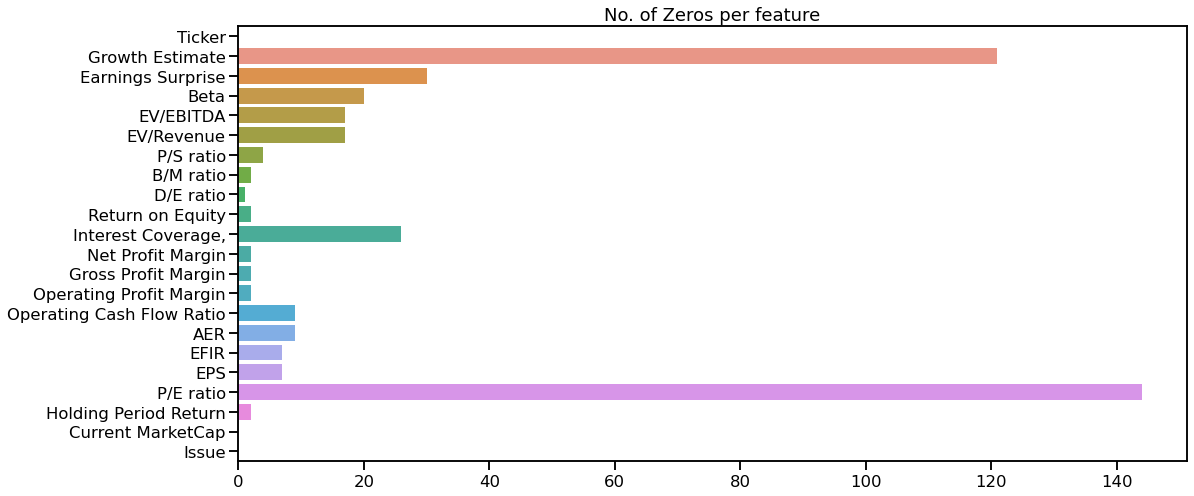

In [78]:
def plot_zeros(df):
    plt.subplots(figsize=(17,8))
    zeros = len(df) - df.astype(bool).sum(axis=0)
    sns.barplot(x=zeros,y=zeros.index).set(title="No. of Zeros per feature")
    sns.set_context("talk")
plot_zeros(df)

* Growth estimate (`GE`) and P/E ratio (`PE`) are >50% filled with null values. I'll drop them. P/E ratio is null because it is displayed as N/A if earnings (net income) is negative, which is common in the tech industry. However, intuitively, a model will correlate P/E ratios of 0 and below with high returns, which defeats the purpose, so I have to drop it. 

## 2.4 Exploratory Data Analysis
 
* Unfortunately, from the histograms we see a a crazy amount of extreme values/outliers (winners being `P/S` ratio of 6730 and `ICR` of 12000!). This influences what kind of scaling to use in feature engineering.
* In terms of distributions, most seem normal, with some skew. Most variables have very high <i>Kurtosis</i>, thus being <i> platykurtic</i>. This might pose an issue.

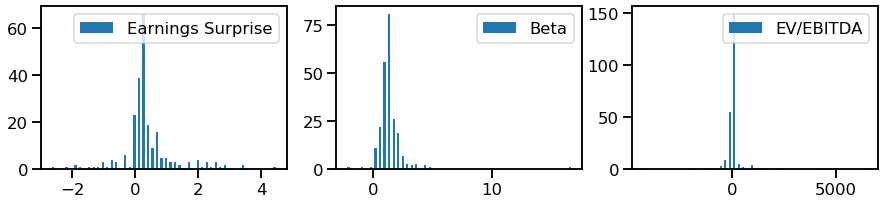

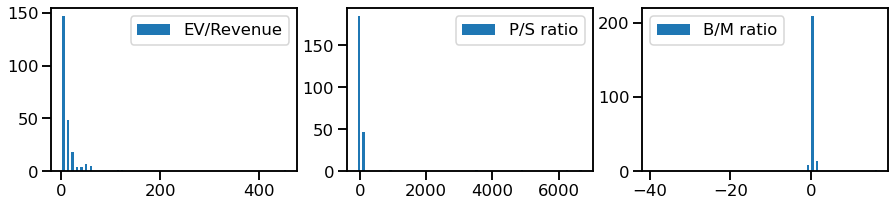

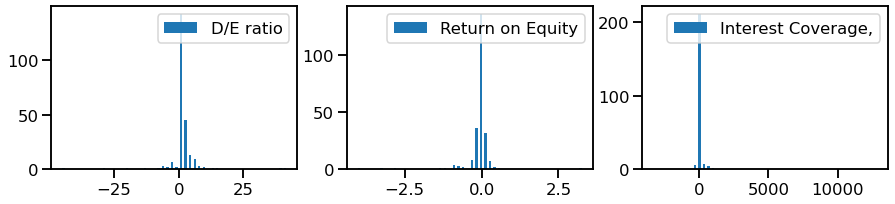

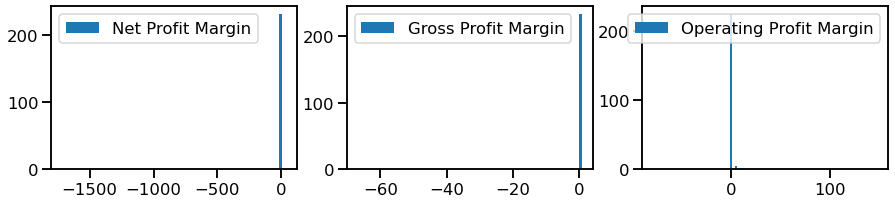

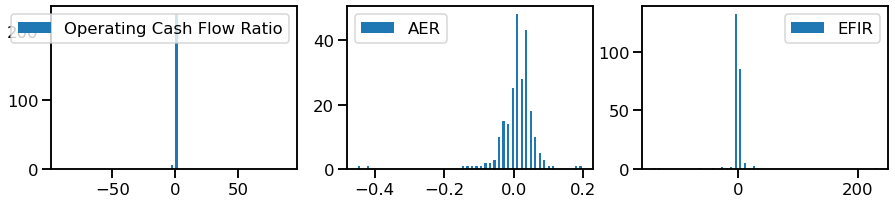

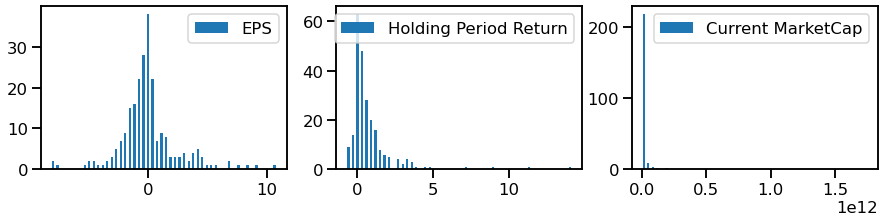

In [79]:

def impute(df):
    simp = SimpleImputer(missing_values = 0, strategy = "median")
    df.iloc[:,1:-5] = simp.fit_transform(df.iloc[:,1:-5])
    #drop the sparse features
    del df["Growth Estimate"]
    del df["P/E ratio"]
    return df


def continuous_histogram(features, df):
    for i in range(len(features)):
        if i % 3 == 0:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
            ax1.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
            ax1.legend(loc = "best")
        elif i % 3 == 1:
            ax2.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
            ax2.legend(loc = "best")
        else:
            ax3.hist(df[features[i]], bins = 50, rwidth = 0.5, label=features[i])
            ax3.legend(loc = "best")
    
    plt.show()
    

df = impute(df)
#plot histograms
features = df.columns[1:-1]
continuous_histogram(features,df)

## 2.5 Feature Engineering

* As per the histograms, unfortunately most distributions are highly kurtotic with extreme outliers on either end and many values clustered at the median/mean. For example, if `AGMH` with 500X `EV/Ebitda` has really bad returns, then the algorithm will heavily weigh the importance of said attribute.

<a href="https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks">https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks</a>
<br>
<a href="https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02"> https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02</a>
<br>
<a href="https://stats.stackexchange.com/questions/88218/transforming-extremely-skewed-distributions">https://stats.stackexchange.com/questions/88218/transforming-extremely-skewed-distributions</a>


<b>Scaling</b>:
<ul>
    <li> StandardScaler - scales to $Z \sim N(0,1)$ by subtracting $\mu$ and dividing by $\sigma$.
    <li> MinMaxScaler - scales to $\frac{X - X_{min}}{X_{max} - X_{min}}$, min: 0 and max: 1
    <li> RobustScaler - scales to $\frac{X - Q_1(x)}{Q_{3}(X) - Q_{1}{X}}$, divides by IQR
</ul>
Random forests are not affected by distribution, but Neural Networks prefer to have unit mean and variance. Thus, we will lean towards Robust and Standard Scaling to reduce outlier impact and get that nice $z$-dist.
<br>

<b>Transformation</b>:

For skewed and leptokurtic values, these are the transforms:
<ul>
    <li> Log/Natural Log transform $\ln(1+x)$
    <li> Box Cox transform with a parameter $\lambda$ (stronger than log for right skew, but requires +ve values $\mathbb{R}^+$)
    <li> Leptokurtic values can be scaled with heavy tailed Lambert W x F distributions (with package Gaussianize, but I discovered this after finishing)
</ul>

Thus, `df` --> `impute()` --> `preprocesser()` --> `return df`



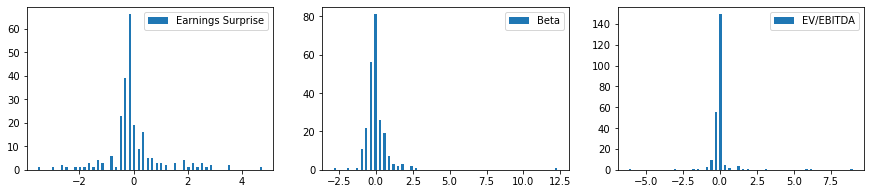

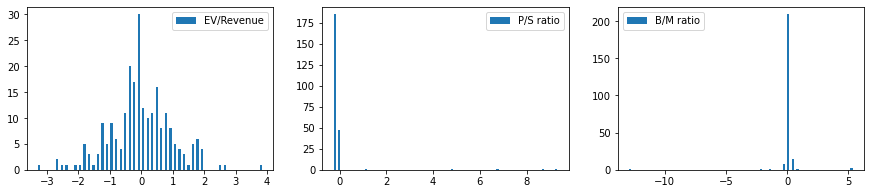

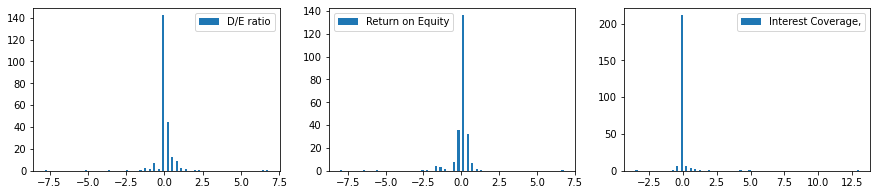

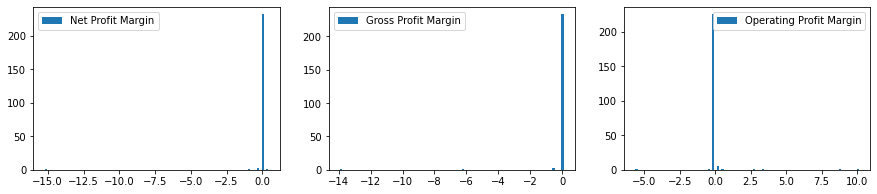

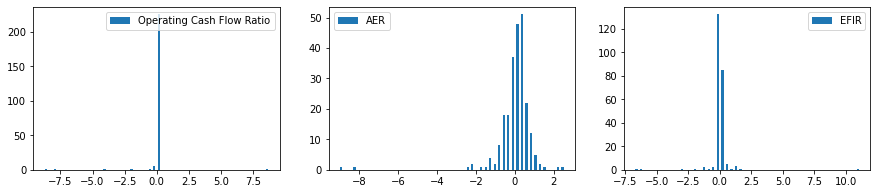

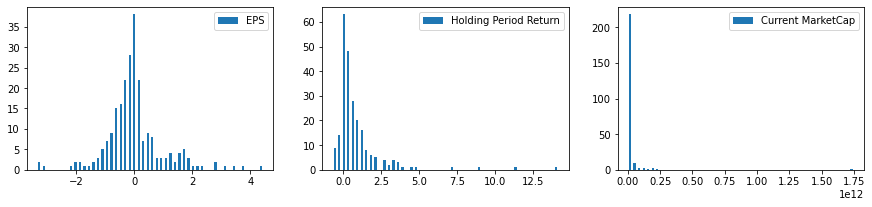

In [10]:
def preprocesser(df):    
    
    #boxcox and log
    df["EV/Revenue"],_ = stats.boxcox(df["EV/Revenue"])
    df["AER"] = np.log1p(df["AER"])
    
    #scaling
    robust = RobustScaler()
    df.iloc[:,1:-3] = robust.fit_transform(df.iloc[:,1:-3])
    standard = StandardScaler()
    df.iloc[:,1:-3] = standard.fit_transform(df.iloc[:,1:-3])
    
    return df

df = preprocesser(df)
features = df.columns[1:-1]
continuous_histogram(features,df)

Sadly, the log transforms didn't have much impact due to the imputation of the missing values.

## 2.6 Train, cross validation, test split

When it comes to TTS, there are several key differences between a normal project and this one: 

* <b>Finance data is noisy (past != future)</b>: Usually the objective is to compare between multiple models and decide on the best one. In finance, past data on prices does not always indicate the future, so model performance on the test and CV sets (if any) should mean little. Bummer.

* <b>Data period to test on</b>: Normally, one would test using data from the same period, but to predict future returns, we have to test on data on the most current period 

* <b> Test tickers</b>: I manually went through and picked the test set, to try and get the full spectrum of Market Cap for the firm + cover interesting companies. It made no sense to me at least to randomly split `TTS`. Also, I will use the entire dataset as `Train`, for the aforementioned reason (`Test` has data from a different period despite Ticker overlap).





In [80]:
#prep the test set
test_tickers = ["MSFT","ADBE","ORCL","SAP","SQ","UBER","WORK","WDAY","TTD","MDB","ZIXI","ZS","CSGS","MGIC","SEAC","EVOL"]
#test_df = create_df(test_tickers,train=False)
#test_df.to_csv("df_test.csv", encoding = 'utf-8')
test_df = pd.read_csv("df_test.csv")
test_df = test_df.round(4)
test_df = impute(test_df)
test_df = preprocesser(test_df)

x_test = test_df.iloc[:,1:-3]

#prep the train set
x_train = df.iloc[:,1:-3]
y_train = df.iloc[:,-3]

In [81]:
#folds object
kf10 = KFold(n_splits=10, shuffle=True,random_state=0)

# 3. Training the models

* <b> Deciding on a loss</b>:  `Mean Squared Error (L2)` or `Mean Absolute Error (L1)` or `Root Mean Squared Error`. For interpretability I'll use the latter.

However, while I'd use `GridSearchCV` to do both cross-validation and hyperparameter tuning and evaluate the mean CV score, I am not sure how to replicate cross-validation in `PyTorch`, so I won't use CV for the ANN, just train and test (which technically defeats the purpose of doing CV for the RF since it lacks a fair comparison)

## 3.1 Training the Random Forest

<ul>
    <li> Scoring Object (MSE, MAE, RMSE)
    <li> Estimator Objects 
    <li> Automatic Cross Validator Object (GSCV)
</ul>        

       
* From preliminary training, it seems that the problem is not overfitting the data as initially thought, but underfitting, because as I increase `max_depth`, the test error decreases, and `max_features` has it's best parameter as `auto`, which are both parameters that lead to deeper trees that conventionally overfit, but in this case, it improves CV performance. 


The most important features are `Beta`, `P/S` ratio, `EV/Revenue`, and `AER`. Importances were the same with or without transforms (I tried again without), so this means it wasn't the transforms that are influencing the importance.

In [98]:


def grid_object(x,y, estimator, params, scoring, cv):
    """returns the fitted GSCV object"""
    grid_rf = GridSearchCV(estimator = estimator, param_grid = params, scoring = scoring, cv = cv,
                           n_jobs = -1, return_train_score = True)
    grid_rf.fit(x,y)
    return grid_rf

def report_GridSearchCV_results(grid):
    print("- Best combination of hyperparams:\n", grid.best_params_, "\n")
    print("- Best mean_test_score:\n", grid.best_score_, "\n")
    
    scores = []
    for i in range(grid.n_splits_):
        scores.append(grid.cv_results_['split{}_test_score'.format(i)][grid.best_index_])
    print("- Score by fold for best estimator:\n", scores, "\n")
    
    # View top 10 hyperparams combinations by mean_test_score (averaged CV score over all folds)
    print("- Top 10 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(grid.cv_results_)[["rank_test_score", "mean_test_score","mean_train_score"] 
                                            + ["param_" + param for param in grid.param_grid]]
              .sort_values(by = "mean_test_score", ascending = False)
              .set_index("rank_test_score").head(10))
    
    return None


def plot_feature_importance(estimator,df, model_name):
    
    plt.figure(figsize = (10, 10))
    features, importances = df.columns, estimator.best_estimator_.feature_importances_
    sns.barplot(importances,features, orient="h").set(title="{} || Avg. feature importance for best hyperparams".format(model_name))
    sns.set_context("talk")
    plt.show()    

    return None

def plot_coef(estimator,df, model_name):
    
    plt.figure(figsize = (15, 8))
    features, importances = df.columns, estimator.best_estimator_.coef_
    sns.barplot(importances,features, orient="h").set(title="{} || Coefficients for best hyperparams".format(model_name))
    sns.set_context("talk")
    plt.show()    

    return None

In [83]:

#scoring
mse = "neg_mean_squared_error"
rmse = "neg_root_mean_squared_error"
mae = "neg_mean_absolute_error"
mape = "neg_mean_absolute_percentage_error"
#parameter grid
params_rf = {"max_depth": [2, 3, 4,8,13],
              "min_samples_leaf": [1,10,20],
              'max_features': [2, 3, 4, "auto"]}
#estimator
rf = RandomForestRegressor(random_state=0)
#cross-validation object
grid_rf = grid_object(x_train,y_train,rf,params_rf,rmse,kf10)

In [84]:
report_GridSearchCV_results(grid_rf)

- Best combination of hyperparams:
 {'max_depth': 13, 'max_features': 2, 'min_samples_leaf': 1} 

- Best mean_test_score:
 -1.3441233614111003 

- Score by fold for best estimator:
 [-1.3207962043356687, -1.9336436169021956, -1.2651771906006632, -0.8910222411628862, -2.3983713682130148, -1.5023176635231001, -0.8493867924289775, -1.5513167144061661, -1.0471158987801235, -0.6820859237582064] 

- Top 10 hyperparams combinations by mean_test_score:


,mean_test_score,mean_train_score,param_max_depth,param_min_samples_leaf,param_max_features
rank_test_score,,,,,
1,-1.344123,-0.526440,13,1,2
2,-1.344835,-0.586320,8,1,3
3,-1.348921,-0.577058,8,1,auto
4,-1.350157,-0.523192,13,1,3
5,-1.352903,-0.534435,13,1,auto
6,-1.356693,-1.393142,13,20,auto
6,-1.356693,-1.393142,8,20,auto
8,-1.356869,-1.393409,4,20,auto
9,-1.357785,-1.397977,3,20,auto


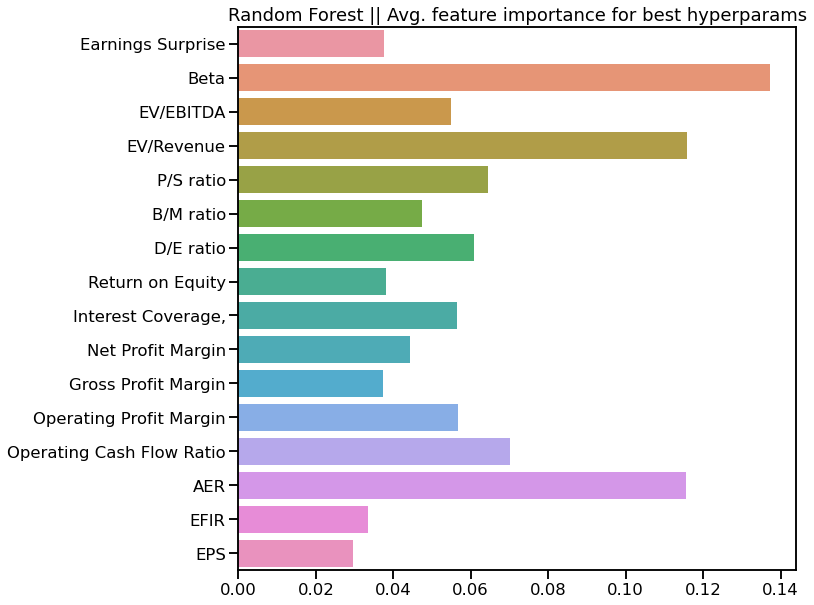

In [99]:
plot_feature_importance(grid_rf,x_train,"Random Forest")

## 3.2 Training the Ridge Regressor

* So now I want to replicate the same thing, but with Ridge Regression, mainly to check out the <b>coefficients</b>, since the feature importances of the RF do not tell us whether it is $+ve$ or $-ve$ values of features that contribute to higher returns.

In [17]:

#parameter grid
params_ridge = {'alpha':[0.01, 0.1,1, 10, 100, 1000]}
#estimator
ridge = Ridge()
#cross-validation object
grid_ridge = grid_object(x_train,y_train,ridge,params_ridge,rmse,kf10)

In [18]:
report_GridSearchCV_results(grid_ridge)

- Best combination of hyperparams:
 {'alpha': 1000} 

- Best mean_test_score:
 -1.4071763976620317 

- Score by fold for best estimator:
 [-1.1220317944982774, -2.249575604182732, -0.8852641701874926, -1.042726021511661, -2.9998901581026267, -1.4797532125780808, -0.7614323313171854, -2.002990560011623, -0.7841620589059992, -0.7439380653246391] 

- Top 10 hyperparams combinations by mean_test_score:


,mean_test_score,mean_train_score,param_alpha
rank_test_score,,,
1,-1.407176,-1.549616,1000
2,-1.457079,-1.438046,100
3,-1.668830,-1.390113,10
4,-1.938609,-1.378778,1
5,-3.104502,-1.372262,0.1
6,-6.743999,-1.370866,0.01


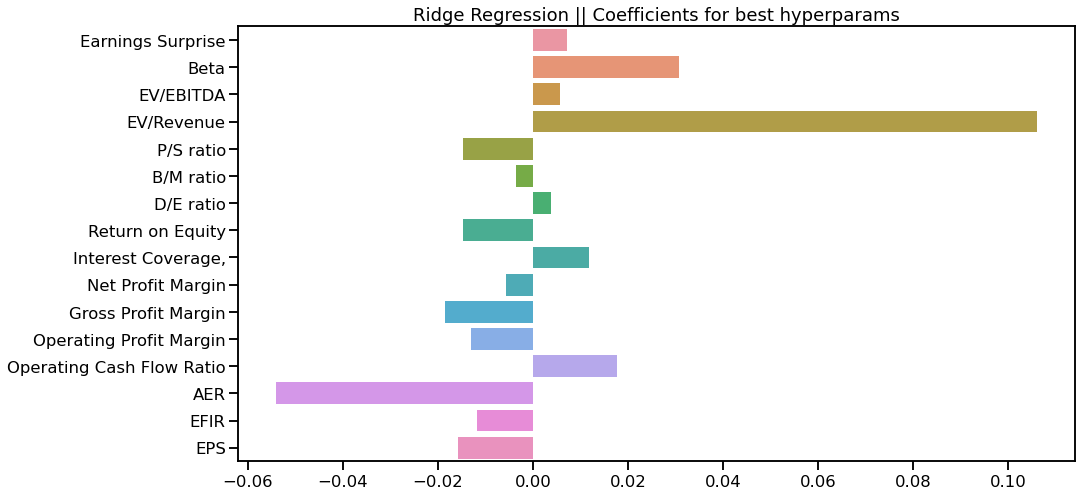

In [47]:
plot_coef(grid_ridge,x_train,"Ridge Regression")

## 3.3 Training the Neural Network

Now let's use `PyTorch` to build and train a simple `ANN` on the dataset. From my crash course, the procedure should be as such:

<b>Process:</b>

`Df` to `Np` array to `Tensor` --> `TensorDataset` object --> `DataLoader` object --> define `network` --> define `optimizer` & `loss` --> `training loop` (reset gradients, forward pass, compute loss, backprop, gradient descent and update weights, evaluate loss, repeat) --> evaluate train performance --> test

As of now I'm not too sure how to do CV on a NN (probably involves some `DataLoader` skills), but given the underfitting we've observed, I guess this isn't really that much of an issue.

In [20]:
import torch.tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim


print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

GeForce GTX 1650 with Max-Q Design
True


In [21]:
#Tensors
def df_to_tensor(df, requires_grad):
    tsr = torch.tensor(np.array(df), device = 0, requires_grad = requires_grad)
    return tsr

x_train_t = df_to_tensor(x_train,True).float()
y_train_t = df_to_tensor(y_train,True).unsqueeze(1).float()
x_test_t = df_to_tensor(x_test,True).float()

#DataLoaders
train_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size = 10, shuffle = True)
#x_test_t = DataLoader(TensorDataset(x_test_t), batch_size = 5, shuffle = True)

print(f"x_train shape:{x_train_t.shape}\n",
     f"y_train shape:{y_train_t.shape}")



x_train shape:torch.Size([237, 16])
 y_train shape:torch.Size([237, 1])


<b> Constructing the network </b>:
    
_Issues_:

Number of layers and nodes (there seems to be many contrasting opinions), learning rate, number of epochs, and how to address overfitting. 

For <i><b> overfitting </b></i>:
    <ol>
        <li> Dropout layers (nn.dropout) </li> 
        <li> L2/weight decay (optimizer parameter weight_decay- impacts the gradient weights) </li>
        <li> L1 (nn.L1Loss) </li>
        <li> Batch Norm (nn.BatchNorm1d/2d- normalizes activations) or  Normalize input data (Already done)</li>
    </ol>
    
At the same time, the previous algorithms all underfit, likely because the data is too noisy.

In [22]:
#net
class Net(nn.Module):
    def __init__(self,nodes):
        super(Net,self).__init__()
        self.nodes = nodes
        #input layer: 16 features as input, 64 as output
        self.inputlayer = nn.Linear(16,nodes)
        self.fc2 = nn.Linear(nodes,nodes)
        self.fc3 = nn.Linear(nodes,nodes)
        self.fc4 = nn.Linear(nodes,nodes)
        self.fc5 = nn.Linear(nodes,nodes)
    
        self.outputlayer = nn.Linear(nodes,1) 
    def forward(self,x):
        x = F.relu(self.inputlayer(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.outputlayer(x)
        return x
net = Net(64)
#optimizer & loss 
optimizer = optim.Adam(net.parameters(), lr = 0.005)
l1loss = nn.L1Loss() 
l2loss = nn.MSELoss()

In [23]:

#model to GPU
net.to(0)
#training loop
epochs = 100
running_loss = 0.0
loss_graph = []
for epoch in range(epochs):
    epoch_loss= []
    for i,row in enumerate(train_loader,0):
        x, y = row
        #clear gradient
        net.zero_grad()
        #forward prop
        y_hat = net(x)
        #compute loss
        loss = torch.sqrt(l2loss(y_hat,y))
        #compute gradients
        loss.backward()
        #update weights with gradient descent
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if i % 10 == 9:    # print every 10 mini-batches
            #print('[%d, %5d] loss: %.3f' %
                  #(epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    loss_graph.append(sum(epoch_loss)/len(epoch_loss))
        
    

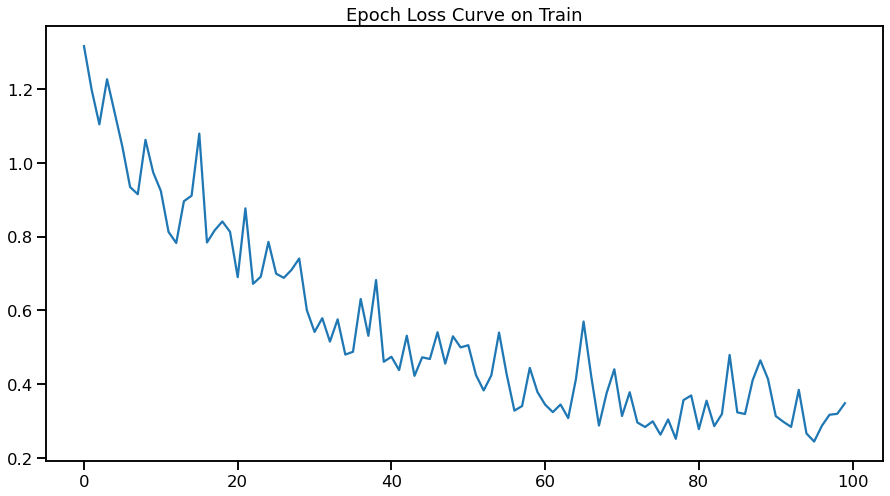

In [48]:
plt.figure(figsize = (15, 8))
loss_graph = pd.Series(loss_graph)
sns.lineplot(loss_graph.index,loss_graph).set(title = "Epoch Loss Curve on Train")
sns.set_context("talk")


* Well finally! After several failed attempts at playing with Hyperparameters, my network finally converges. For my first 5 or so attempts, the network didn't converge at all, and the epoch loss hovered around 1.1, because my $Y$ tensor was missing a dimension. It converges to around the same `mean train loss` on the `RF`, so I presume it should underfit as well.

# 4. Testing

* Having trained the models, now we want to test it. Do note that testing is merely for curiousity and not to assess model performance, because ultimately, we are unsure how much generalization there is (as explained above, `CV` scores are not reliable because of the nature of markets).

In [25]:
import plotnine
def test_models(x_test):
    test_rf = grid_rf.best_estimator_.predict(x_test).round(4)
    test_ridge = grid_ridge.best_estimator_.predict(x_test).round(4)
    test_net = np.array(net(x_test_t).cpu().detach().numpy().reshape(16)).round(4)
    
    #print(f"Predicted returns for 2020-2021 for the test set (units in annual HPR and %):\n")
    #print(f"RF: {test_rf}\n")
    #print(f"ANN: {test_net}\n")
    #print(f"Ridge: {test_ridge}\n")
    test_results = pd.DataFrame({'RF': test_rf, "ANN": test_net, 'Ridge': test_ridge }, index = test_df.Ticker)
    return test_results.reset_index()

test_results = test_models(x_test)
test_results.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Ticker,MSFT,ADBE,ORCL,SAP,SQ,UBER,WORK,WDAY,TTD,MDB,ZIXI,ZS,CSGS,MGIC,SEAC,EVOL
RF,2.1585,3.3541,2.7096,1.8591,3.1143,1.2158,2.3593,1.195,3.9305,2.589,1.5942,2.79,1.806,1.7936,2.9603,2.4671
ANN,0.1943,0.118,0.3628,0.229,1.9932,4.5464,4.5892,-0.0405,8.2228,5.7485,1.4007,4.8669,0.1536,0.2955,4.6414,1.5417
Ridge,0.7396,0.6784,0.7283,0.6921,0.9877,0.94,0.9443,0.8412,0.9947,0.9277,0.7239,0.9503,0.6439,0.7441,0.9772,0.6357


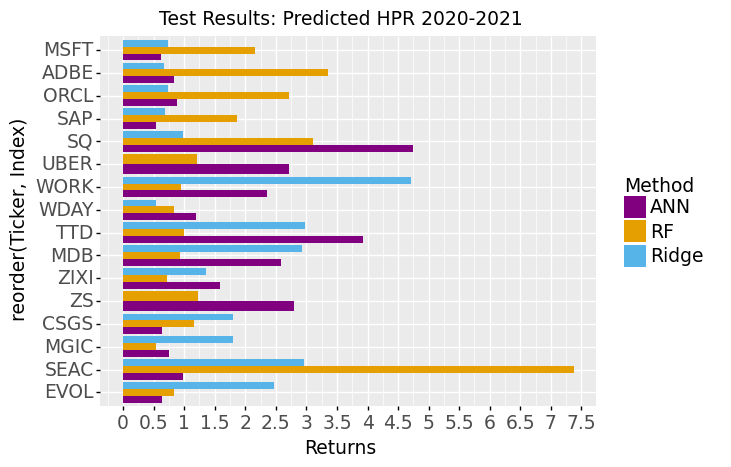

<ggplot: (120201380642)>

In [70]:
tr = pd.read_csv("test_results.csv")
from plotnine import *
ggplot(tr) + geom_col(aes(x = 'reorder(Ticker, Index)', y = "Returns", fill = "Method"),position = "dodge") + scale_y_continuous(breaks = np.arange(0,8, 0.5)) + scale_fill_manual(values=["purple", "#E69F00", "#56B4E9"])+ coord_flip() + theme(text = element_text(size = 13.5)) +ggtitle("Test Results: Predicted HPR 2020-2021")  

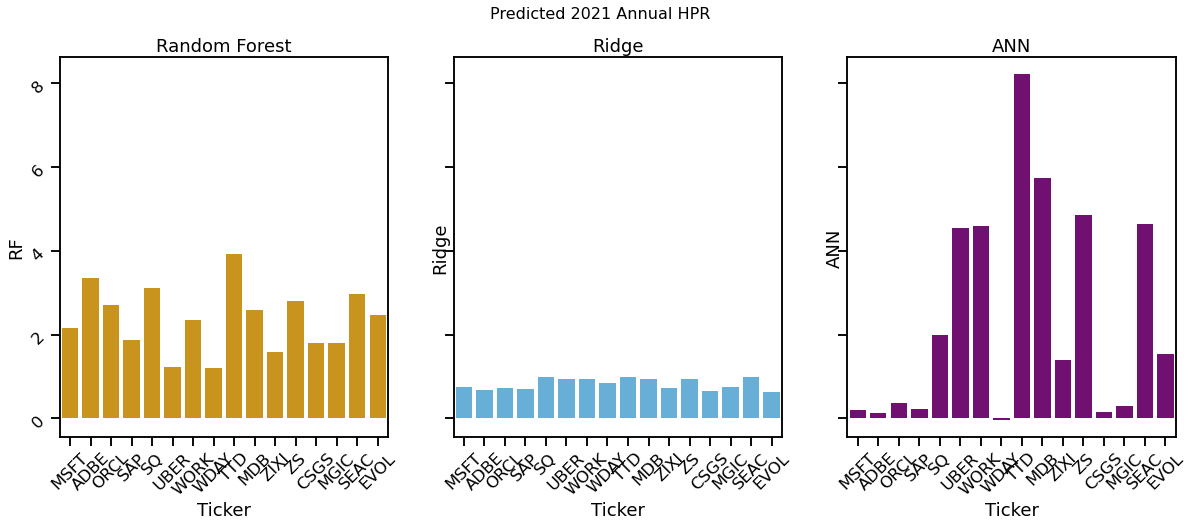

In [60]:
fig, axs = plt.subplots(figsize = (20,7),ncols=3, sharey= True)
sns.barplot(x='Ticker', y='RF', data=test_results, color = "#E69F00",ax=axs[0]).set(title = "Random Forest")
sns.barplot(x='Ticker', y='Ridge', data=test_results, color = "#56B4E9",ax=axs[1]).set(title = "Ridge")
sns.barplot(x='Ticker', y='ANN', data=test_results, color = "purple",ax=axs[2]).set(title = "ANN")
for i in range(3):
    axs[i].tick_params(labelrotation=45)
fig.suptitle("Predicted 2021 Annual HPR", fontsize=16)
sns.set_context("talk")


From the results, the `Random Forest` and `ANN` are far more optimistic than the `Ridge`. This is likely due to the regularization/shrinking effect of the coefficients. Interestingly, the `ANN` shows far more varied results than the `RF`, perhaps it being better able to interpret nonlinear relationships in the data.

# 5. Conclusion

## 5.1 Interpretation

So, what have we learned from this? Can the fundamentals really be learned by a model which then outputs predicted returns effectively? Unfortunately, I think the answer is no in this context at least, but given proper data and a larger dataset it might work.

<b>Underfitting vs Overfitting</b>: 
* The models all seem to have underfit, meaning high `bias`. This is probably because the relationships may not actually exist between the `x` and `y` variables. As I said, it's probably due to the industry choice and 2020 in general, which throws fundamentals out of the window. Thus, given the small sample size, the models don't seem useful for predictive purposes. `RF` CV mean RMSE was 1.34, and the SD of train HPR was 1.6, so that's like 20% accuracy (assuming returns are normal, but they look more lognormal than normal). At the end, I kind of realized for leptokurtic data and outliers, quantile regression might work better, but alas, it was too late.

<b>Interpreting feature importances</b>: 
* The `Random Forest` has the most important features as: `Beta`, `EV/Revenue`, and `AER`. Are these meaningful? Well in the context of the data these were the most important features. High `Beta` makes sense, since the stock market and the tech industry have gone up in this period, with all the macroeconomic policies of the Fed being implemented. High `EV/Revenue` indicates that it was overvalued companies getting the highest returns. As for `AER`, the coefficients for `Ridge` were negative, so a negative `AER` actually contributes to returns, which implies negative `CFO`. I guess this just means younger companies have better returns. I think one issue was the leptokurtic data and another was the noise that prevents the importances from making too much sense.

<b> PyTorch and Sklearn </b>:
* At the very least, this project gave me the opportunity to implement some ML algorithms, especially `PyTorch` which I wanted to try building a Neural Network with. Albeit this was a very simple net, but in future projects I would look to do more advanced stuff, once I learn the other architectures like RNNs, LSTMs, GANS, transformers etc. 

<b> Data Cleaning </b>:
* Most annoyingly, I would say most of the time was spent on getting the dataset ready. The actual preprocessing and training was relatively quick, with the exception of building the `NN` with `PyTorch`, in which I had to figure out the syntax and some mechanics of the `Tensor` datatype. At first, my net gave the same prediction for all test inputs. After trying everything, later figured this was due to the `.shape` of my tensors lacked 1 extra dimension which was solved with `unsqueeze()`.

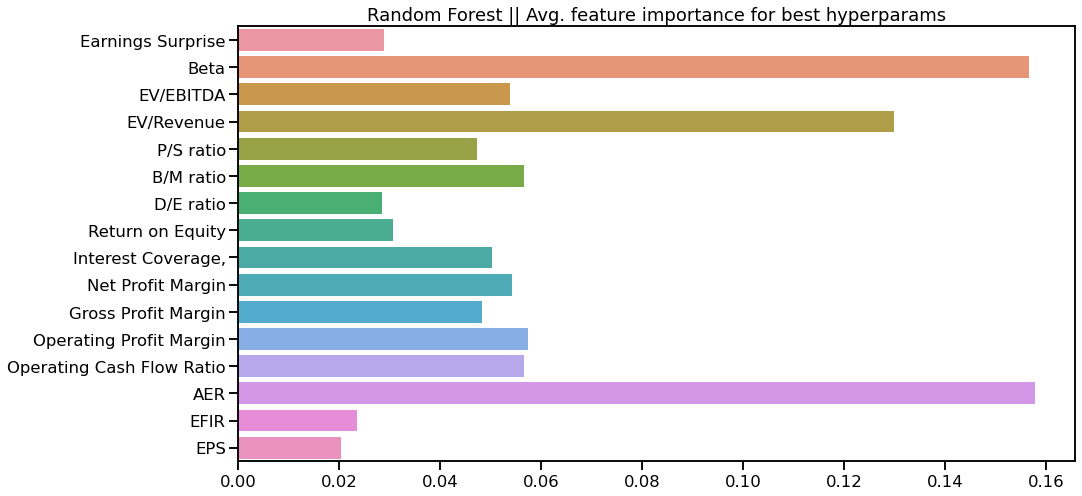

In [61]:
plot_feature_importance(grid_rf,x_train,"Random Forest")

##  5.2 The road ahead

Unfortunately, the original idea was to use fundamental data but predict PE exit returns instead, aka IRR, or whichever exit metric. The reason being simply that LBO targets have a specific profile that can be reflected in the fundamentals, so in theory the relationship between the predictor and target should be quite strong. Maybe this is what some of the AI investing PE firms are doing, like EQT ventures. However, asset-level exit IRR was simply undisclosed (Even on Preqin demo). As for this idea, I definitely think a large scale project with a huge dataset with proper data might work, but that's not for me to do.

<b>What's next</b>: So next up, I will probably go back to learning more math and stats, having stopped prematurely. ML wise, I'd look to learn in the directions of NLP and forecasting, which are more applicable to my major.